# Libraries

In [2]:
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from textblob import TextBlob 
from sklearn.ensemble import GradientBoostingRegressor
from flaml import AutoML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier


# Loading the Files

Download the csv files into the `data/` directory.

Loading and displaying data info...
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Inte

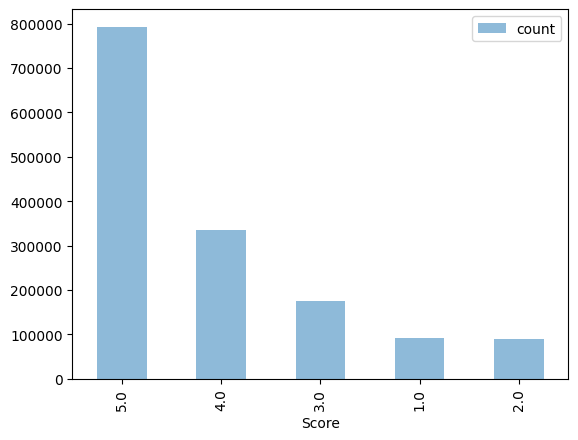


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [45]:
print("Loading and displaying data info...")
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

# Plot score distribution

# trainingSet['UserId'].value_counts().nlargest(100).plot(kind = 'bar', legend = True, alpha = 0.5)
# plt.title('Top 100 Reviewers')

# # Monthly review distribution
# trainingSet['Month'].value_counts().sort_index().plot(kind='bar', legend=True, alpha=0.5)
# plt.title('Monthly Review Distribution')
# plt.xlabel('Month')
# plt.ylabel('Review Count')
# plt.show()

# # Distribution of reviews by day of the week
# trainingSet['DayOfWeek'].value_counts().sort_index().plot(kind='bar', legend=True, alpha=0.5)
# plt.title('Review Distribution by Day of the Week')
# plt.xlabel('Day of the Week (0=Monday)')
# plt.ylabel('Review Count')
# plt.show()

# # Distribution of average user scores
# trainingSet['UserMeanScore'].plot(kind='hist', bins=50, legend=True, alpha=0.5)
# plt.title('Distribution of Average User Scores')
# plt.xlabel('User Mean Score')
# plt.ylabel('Frequency')
# plt.show()

# # Top 20 users by review count
# trainingSet['UserReviewCount'].nlargest(20).plot(kind='bar', legend=True, alpha=0.5)
# plt.title('Top 20 Users by Review Count')
# plt.xlabel('User ID')
# plt.ylabel('Review Count')
# plt.show()

# # Distribution of average product scores
# trainingSet['ProductMeanScore'].plot(kind='hist', bins=50, legend=True, alpha=0.5)
# plt.title('Distribution of Average Product Scores')
# plt.xlabel('Product Mean Score')
# plt.ylabel('Frequency')
# plt.show()

# # Top 20 products by review count
# trainingSet['ProductReviewCount'].nlargest(20).plot(kind='bar', legend=True, alpha=0.5)
# plt.title('Top 20 Products by Review Count')
# plt.xlabel('Product ID')
# plt.ylabel('Review Count')
# plt.show()

# # Distribution of review lengths
# trainingSet['ReviewLength'].plot(kind='hist', bins=50, legend=True, alpha=0.5)
# plt.title('Distribution of Review Lengths')
# plt.xlabel('Review Length (words)')
# plt.ylabel('Frequency')
# plt.show()

# # Distribution of text sentiment scores
# trainingSet['TextSentiment'].plot(kind='hist', bins=50, legend=True, alpha=0.5)
# plt.title('Distribution of Text Sentiment Scores')
# plt.xlabel('Sentiment Score')
# plt.ylabel('Frequency')
# plt.show()
# # Distribution of days since the first review for each product
# trainingSet['DaysSinceFirstReview'].plot(kind='hist', bins=50, legend=True, alpha=0.5)
# plt.title('Distribution of Days Since First Review')
# plt.xlabel('Days Since First Review')
# plt.ylabel('Frequency')
# plt.show()

# # Distribution of relative position of reviews within product timelines
# trainingSet['ReviewTimePosition'].plot(kind='hist', bins=50, legend=True, alpha=0.5)
# plt.title('Distribution of Review Time Position')
# plt.xlabel('Position in Timeline (0 to 1)')
# plt.ylabel('Frequency')
# plt.show()

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()
print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features and Create New File

In [46]:
def add_features_to(df, training_data=None):
    """
    Enhanced feature engineering function with additional sophisticated features
    """
    # Basic helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Enhanced helpfulness features
    df['IsHelpful'] = (df['HelpfulnessNumerator'] > 0).astype(int)
    df['HelpfulnessDifference'] = df['HelpfulnessNumerator'] - df['HelpfulnessDenominator']
    df['WeightedHelpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    
    # Time-based features
    time_series = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = time_series.dt.year
    df['Month'] = time_series.dt.month
    df['DayOfWeek'] = time_series.dt.dayofweek
    df['Quarter'] = time_series.dt.quarter
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['DayOfMonth'] = time_series.dt.day
    df['WeekOfYear'] = time_series.dt.isocalendar().week
    df['DayOfYear'] = time_series.dt.dayofyear
    
    # Season encoding
    df['Season'] = df['Month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })
    
    # One-hot encode season
    season_dummies = pd.get_dummies(df['Season'], prefix='Season')
    df = pd.concat([df, season_dummies], axis=1)
    
    # User and Product history features
    if training_data is not None:
        user_stats = training_data.groupby('UserId')['Score'].agg(['mean', 'std', 'median', 'count', 'min', 'max'])
        product_stats = training_data.groupby('ProductId')['Score'].agg(['mean', 'std', 'median', 'count', 'min', 'max'])
        global_mean = training_data['Score'].mean()
    else:
        user_stats = df.groupby('UserId')['Score'].agg(['mean', 'std', 'median', 'count', 'min', 'max'])
        product_stats = df.groupby('ProductId')['Score'].agg(['mean', 'std', 'median', 'count', 'min', 'max'])
        global_mean = df['Score'].mean()
    
    # User statistics
    df['UserMeanScore'] = df['UserId'].map(user_stats['mean'])
    df['UserStdScore'] = df['UserId'].map(user_stats['std'])
    df['UserMedianScore'] = df['UserId'].map(user_stats['median'])
    df['UserReviewCount'] = df['UserId'].map(user_stats['count'])
    df['UserMinScore'] = df['UserId'].map(user_stats['min'])
    df['UserMaxScore'] = df['UserId'].map(user_stats['max'])
    df['UserScoreRange'] = df['UserMaxScore'] - df['UserMinScore']
    
    # Product statistics
    df['ProductMeanScore'] = df['ProductId'].map(product_stats['mean'])
    df['ProductStdScore'] = df['ProductId'].map(product_stats['std'])
    df['ProductMedianScore'] = df['ProductId'].map(product_stats['median'])
    df['ProductReviewCount'] = df['ProductId'].map(product_stats['count'])
    df['ProductMinScore'] = df['ProductId'].map(product_stats['min'])
    df['ProductMaxScore'] = df['ProductId'].map(product_stats['max'])
    df['ProductScoreRange'] = df['ProductMaxScore'] - df['ProductMinScore']
    
    # Fill missing values
    df['UserMeanScore'] = df['UserMeanScore'].fillna(global_mean)
    df['ProductMeanScore'] = df['ProductMeanScore'].fillna(global_mean)
    df = df.fillna({
        'UserStdScore': 0,
        'UserMedianScore': global_mean,
        'UserReviewCount': 0,
        'UserMinScore': global_mean,
        'UserMaxScore': global_mean,
        'UserScoreRange': 0,
        'ProductStdScore': 0,
        'ProductMedianScore': global_mean,
        'ProductReviewCount': 0,
        'ProductMinScore': global_mean,
        'ProductMaxScore': global_mean,
        'ProductScoreRange': 0
    })
    
    # Interaction features
    df['UserProductInteraction'] = df['UserMeanScore'] * df['ProductMeanScore']
    df['UserProductReviewInteraction'] = df['UserReviewCount'] * df['ProductReviewCount']
    df['UserProductStdInteraction'] = df['UserStdScore'] * df['ProductStdScore']
    
    # Text preprocessing
    df['Text'] = df['Text'].fillna("").astype(str)
    df['Summary'] = df['Summary'].fillna("").astype(str)
    
    # Text-based features
    df['ReviewLength'] = df['Text'].apply(lambda x: len(x.split()))
    df['UniqueWords'] = df['Text'].apply(lambda x: len(set(x.split())))
    df['AverageWordLength'] = df['Text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(x.split()))
    df['TextToSummaryRatio'] = df['ReviewLength'] / (df['SummaryLength'] + 1)
    
    # Advanced text features
    df['CapitalWordCount'] = df['Text'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))
    df['ExclamationCount'] = df['Text'].apply(lambda x: x.count('!'))
    df['QuestionCount'] = df['Text'].apply(lambda x: x.count('?'))
    df['DigitCount'] = df['Text'].apply(lambda x: sum(c.isdigit() for c in x))
    df['UniqueWordRatio'] = df['UniqueWords'] / (df['ReviewLength'] + 1)
    
    # Sentiment analysis features
    df['TextSentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['SummarySentiment'] = df['Summary'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['TextSubjectivity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['SummarySubjectivity'] = df['Summary'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['SentimentDiff'] = abs(df['TextSentiment'] - df['SummarySentiment'])
    df['SubjectivityDiff'] = abs(df['TextSubjectivity'] - df['SummarySubjectivity'])
    
    # Review timing features
    if training_data is not None:
        product_first_review = training_data.groupby('ProductId')['Time'].min()
        product_last_review = training_data.groupby('ProductId')['Time'].max()
    else:
        product_first_review = df.groupby('ProductId')['Time'].min()
        product_last_review = df.groupby('ProductId')['Time'].max()
    
    df['DaysSinceFirstReview'] = (df['Time'] - df['ProductId'].map(product_first_review)) / (24 * 60 * 60)
    df['DaysToLastReview'] = (df['ProductId'].map(product_last_review) - df['Time']) / (24 * 60 * 60)
    df['ReviewTimePosition'] = df['DaysSinceFirstReview'] / (df['DaysSinceFirstReview'] + df['DaysToLastReview'])
    
    return df

if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # Add features to submission set using training data statistics
    X_submission = add_features_to(X_submission, trainingSet)
    
    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]
    
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Define X_train and X_submission with existing file

In [6]:
X_train = pd.read_csv("./data/X_train.csv") 
X_submission = pd.read_csv("./data/X_submission.csv")

# Sample + Split into training and testing set

In [7]:

X = X_train.drop(columns=['Score'])
Y = X_train['Score']

# Split the training set into training and testing sets for offline evaluation
X_train, X_test, Y_train, Y_test = train_test_split(
    X,  # Features (excluding 'Score')
    Y,  # Target variable ('Score')
    test_size=0.25,  # 25% of the data will be used as the testing set
    random_state=0  # For reproducibility of results
)

# Check the dimensions of the resulting datasets
print(f"Training Set Shape: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Testing Set Shape: X_test: {X_test.shape}, Y_test: {Y_test.shape}")


Training Set Shape: X_train: (1114005, 62), Y_train: (1114005,)
Testing Set Shape: X_test: (371336, 62), Y_test: (371336,)


# Feature Selection

In [8]:
features = [
    # Helpfulness features
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Helpfulness',
    'IsHelpful',
    'HelpfulnessDifference',
    'WeightedHelpfulness',
    'HelpfulnessRatio',
    
    # Time-based features
    'Year',
    'Month',
    'DayOfWeek',
    'Quarter',
    'IsWeekend',
    'DayOfMonth',
    'WeekOfYear',
    'DayOfYear',
    'Season_Fall',
    'Season_Spring',
    'Season_Summer',
    'Season_Winter',
    
    # User statistics
    'UserMeanScore',
    'UserStdScore',
    'UserMedianScore',
    'UserReviewCount',
    'UserMinScore',
    'UserMaxScore',
    'UserScoreRange',
    
    # Product statistics
    'ProductMeanScore',
    'ProductStdScore',
    'ProductMedianScore',
    'ProductReviewCount',
    'ProductMinScore',
    'ProductMaxScore',
    'ProductScoreRange',
    
    # Interaction features
    'UserProductInteraction',
    'UserProductReviewInteraction',
    'UserProductStdInteraction',
    
    # Basic text features
    'ReviewLength',
    'UniqueWords',
    'AverageWordLength',
    'SummaryLength',
    'TextToSummaryRatio',
    'UniqueWordRatio',
    
    # Advanced text features
    'CapitalWordCount',
    'ExclamationCount',
    'QuestionCount',
    'DigitCount',
    
    # Sentiment features
    'TextSentiment',
    'SummarySentiment',
    'TextSubjectivity',
    'SummarySubjectivity',
    'SentimentDiff',
    'SubjectivityDiff',
    
    # Review timing features
    'DaysSinceFirstReview',
    'DaysToLastReview',
    'ReviewTimePosition'
]


# Selecting features for training and testing
X_train_select = X_train[features]
X_test_select = X_test[features]  # Assuming X_test has been defined similarly
X_submission_select = X_submission[features]


# Model


In [50]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train_select, Y_train)

Y_test_predictions = model.predict(X_test_select)


# Create submission file

Accuracy on testing set =  0.6913469203093694


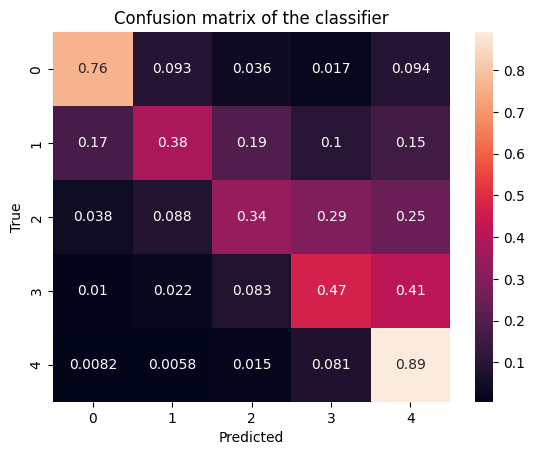

In [51]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [52]:
# Check for missing values
missing_values = X_submission_select.isnull().sum()
print("Missing values per feature:\n", missing_values[missing_values > 0])

# Impute missing values with mean or another appropriate strategy
X_submission_select.fillna(X_submission_select.mean(), inplace=True)

# Verify that all missing values are handled
print("Missing values after imputation:\n", X_submission_select.isnull().sum().sum())

# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

Missing values per feature:
 Series([], dtype: int64)


/var/folders/9l/x_h582t16xv7f088b4ccvcp40000gn/T/ipykernel_17992/3757845480.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submission_select.fillna(X_submission_select.mean(), inplace=True)


Missing values after imputation:
 0
